Author: Jose Caloca


Date: 21/04/2023

In [1]:
#!pip install aequitas
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
from aequitas.plotting import Plot
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', 100)

## load the dataset

In [2]:
path="./data/model_output.csv"
df = pd.read_csv(path)
df.head()

,Sex,Prob_default,Predicted_default,Realised_default
0,male,0.070398,0,0
1,female,0.680953,1,1
2,male,0.066914,0,0
3,male,0.612084,1,0
4,male,0.470040,1,1


In [3]:
df = df.set_index('Prob_default')
df = df.rename(columns={"Realised_default": "label_value", "Predicted_default":"score"})

In [4]:
aq_palette = sns.diverging_palette(225, 35, n=2)

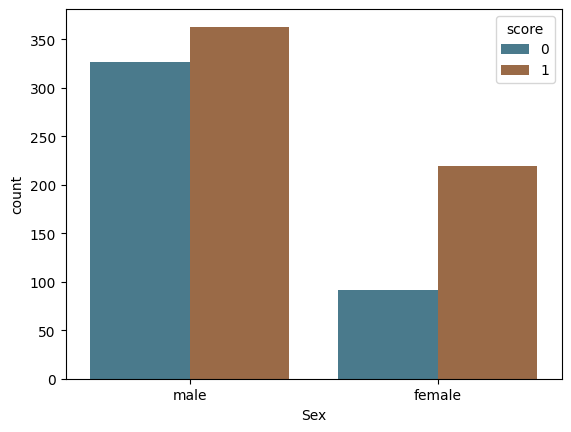

In [5]:
preds_by_sex = sns.countplot(x="Sex", hue="score", data=df, palette=aq_palette)

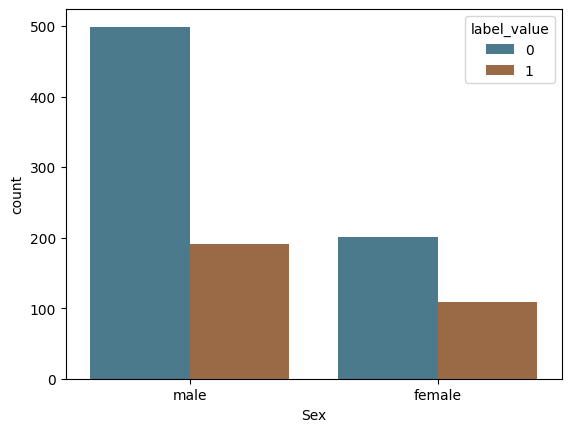

In [6]:
label_by_Sex = sns.countplot(x="Sex", hue="label_value", data=df, palette=aq_palette)

## Putting Aequitas

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


### Data Formatting

Data for this example was preprocessed for compatibility with Aequitas. **The Aequitas tool always requires a `score` column and requires a binary `label_value` column for supervised metrics**, (i.e., False Discovery Rate, False Positive Rate, False Omission Rate, and False Negative Rate).

Preprocessing includes but is not limited to checking for mandatory `score` and `label_value` columns as well as at least one column representing attributes specific to the data set. See [documentation](../input_data.html) for more information about input data.

Note that while `entity_id` is not necessary for this example, Aequitas recognizes `entity_id` as a reserve column name and will not recognize it as an attribute column.

In [7]:
from aequitas.preprocessing import preprocess_input_df
    
df, _ = preprocess_input_df(df)

<a id='xtab'></a>

### What is the distribution of groups, predicted scores, and labels across my dataset?

Aequitas's `Group()` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population. 

<a id='counts_description'></a>
The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Group Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


**Note**: The **`get_crosstabs()`** method expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include `race`, `sex` and `age_cat`. 

In [8]:
g = Group()
xtab, _ = g.get_crosstabs(df)

In [9]:
xtab.head()

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,582,Sex,female,0.917431,0.407960,0.098901,0.543379,0.592040,...,0.706452,119,9,82,100,109,201,310,1000,0.351613
1,0,binary 0/1,582,Sex,male,0.801047,0.579158,0.116208,0.578512,0.420842,...,0.526087,210,38,289,153,191,499,690,1000,0.276812


<a id='xtab_metrics'></a>

### What are bias metrics across groups?

Once you have run the `Group()` class **`get_crosstabs()`** method, you'll have a dataframe of the [group counts](#counts_description) and [group value bias metrics](#counts_description).

The `Group()` class has a **`list_absolute_metrics()`** method, which you can use for faster slicing to view just  counts or bias metrics.

In [10]:
absolute_metrics = g.list_absolute_metrics(xtab)
absolute_metrics

['tpr',
 'tnr',
 'for',
 'fdr',
 'fpr',
 'fnr',
 'npv',
 'precision',
 'ppr',
 'pprev',
 'prev']

#### View calculated counts across sample population groups

In [11]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,582,Sex,female,219,91,119,9,82,100,109,201,310,1000
1,0,binary 0/1,582,Sex,male,363,327,210,38,289,153,191,499,690,1000


#### View calculated absolute metrics for each sample population group

In [12]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Sex,female,0.92,0.41,0.10,0.54,0.59,0.08,0.90,0.46,0.38,0.71,0.35
1,Sex,male,0.80,0.58,0.12,0.58,0.42,0.20,0.88,0.42,0.62,0.53,0.28


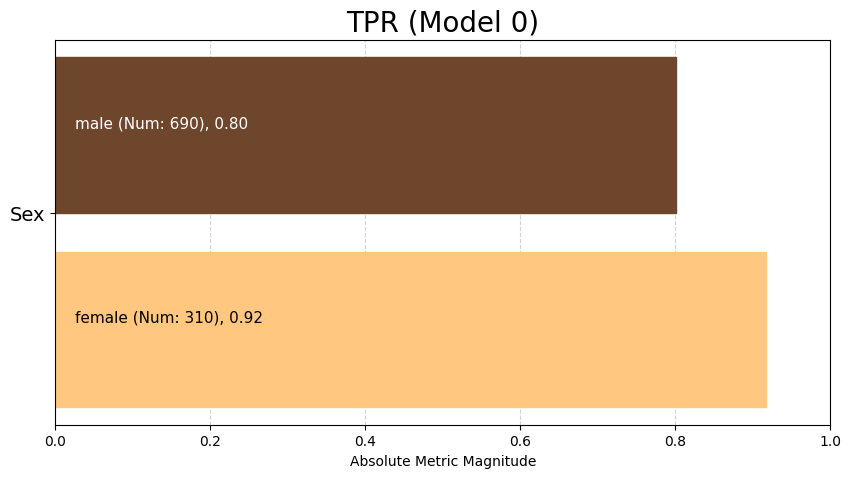

In [13]:
aqp = Plot()
fnr = aqp.plot_group_metric(xtab, 'tpr')

<a id='interpret_bias'></a>

### How do I interpret biases in my model? 
In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that **Male** have a false positive rate (`fpr`) of 42%, while **Female** have a false positive rate of only 59%. This means that Female are far more likely to be falsely labeled as high-risk than Male loan applicants. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

<a id='disparities'></a>

## What levels of disparity exist between population groups?

### _Aequitas Bias() Class_
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for foreigners vs belgians is:
$$Disparity_{FNR} =  \frac{FNR_{Foreigners}}{FNR_{Belgians}}$$ 

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner. 

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below. 

#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

In [14]:
b = Bias()

#### Disparities calculated in relation to a user-specified group for each 

---

attribute

In [15]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'Sex':'male'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,582,Sex,female,0.917431,0.407960,0.098901,0.543379,0.592040,0.082569,0.901099,0.456621,219,91,0.376289,0.706452,119,9,82,100,109,201,310,1000,0.351613,1,1,0.939269,male,0,0.415017,male,0,0.851070,male,0,1.406799,male,0,1.019582,male,0,0.603306,male,1,1.342842,male,1,1.083356,male,0,0.704402,male,0,1.145290,male,0
1,0,binary 0/1,582,Sex,male,0.801047,0.579158,0.116208,0.578512,0.420842,0.198953,0.883792,0.421488,363,327,0.623711,0.526087,210,38,289,153,191,499,690,1000,0.276812,0,0,1.000000,male,0,1.000000,male,0,1.000000,male,0,1.000000,male,0,1.000000,male,0,1.000000,male,0,1.000000,male,0,1.000000,male,0,1.000000,male,0,1.000000,male,0


The `Bias()` class includes a method to quickly return a list of calculated disparities from the dataframe returned by the **`get_disparity_`** methods.

In [16]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,Sex,female,0.939269,0.415017,0.851070,1.406799,1.019582,0.603306,1.342842,1.083356,0.704402,1.145290,1,1,0,0,0,0,0,1,1,0,0,0
1,Sex,male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
metrics = ['tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv', 'precision', 'ppr', 'pprev']
disparity_tolerance = 1.25

# Aequitas Visualizations

In [18]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

### Check for disparities in Sex

In [19]:
ap.disparity(bdf, metrics, 'Sex', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [20]:
ap.absolute(bdf, metrics, 'Sex', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

<a id='disparity_viz'></a>

## How do I visualize disparities in my model?
To visualize disparities in the dataframe returned by one of the `Bias()` class **`get_disparity_`** methods use one of two methods in the Aequitas `Plot()` class:

A particular disparity metric can be specified with **`plot_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_disparity_all()`**.  At least one metric or at least one attribute must be specified when plotting multiple disparities (or the same disparity across multiple attributes). For example, to plot PPR and and Precision disparity for all attributes, specify `metrics=['ppr', 'precision']` with no attribute specified, and to plot default metrics by race, specify `attributes=['race']` and with no metrics specified.

**Reference groups are displayed in grey, and always have a disparity = 1.** Note that disparities greater than 10x reference group will are visualized as 10x, and disparities less than 0.1x reference group are visualized as 0.1x.

Statistical siginificance (at a default value of 0.05) is denoted by two asterisks (**) next to a treemap square's value.

In [21]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The `Fairness()` class includes a method to quickly return a list of fairness determinations from the dataframe returned by the **`get_group_value_fairness()`** method.

In [22]:
parity_detrminations = f.list_parities(fdf)

In [23]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,TypeII Parity,FNR Parity,TNR Parity,Precision Parity,Supervised Fairness,FOR Parity,TypeI Parity,NPV Parity,Equalized Odds,TPR Parity,Impact Parity,Unsupervised Fairness,Statistical Parity,FDR Parity,FPR Parity
0,Sex,female,0.917431,0.407960,0.098901,0.543379,0.592040,0.082569,0.901099,0.456621,0.376289,0.706452,0.351613,0.939269,0.415017,0.851070,1.406799,1.019582,0.603306,1.342842,1.083356,0.704402,1.145290,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0
1,Sex,male,0.801047,0.579158,0.116208,0.578512,0.420842,0.198953,0.883792,0.421488,0.623711,0.526087,0.276812,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Attribute Level Fairness
Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [24]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,Sex,False,False,True,False,True,False,True,False,True,True,False,False,False,False,False


### Overall Fairness
The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`**, returning a dictionary with a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [25]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### Plot a single group metric across all attribute groups.

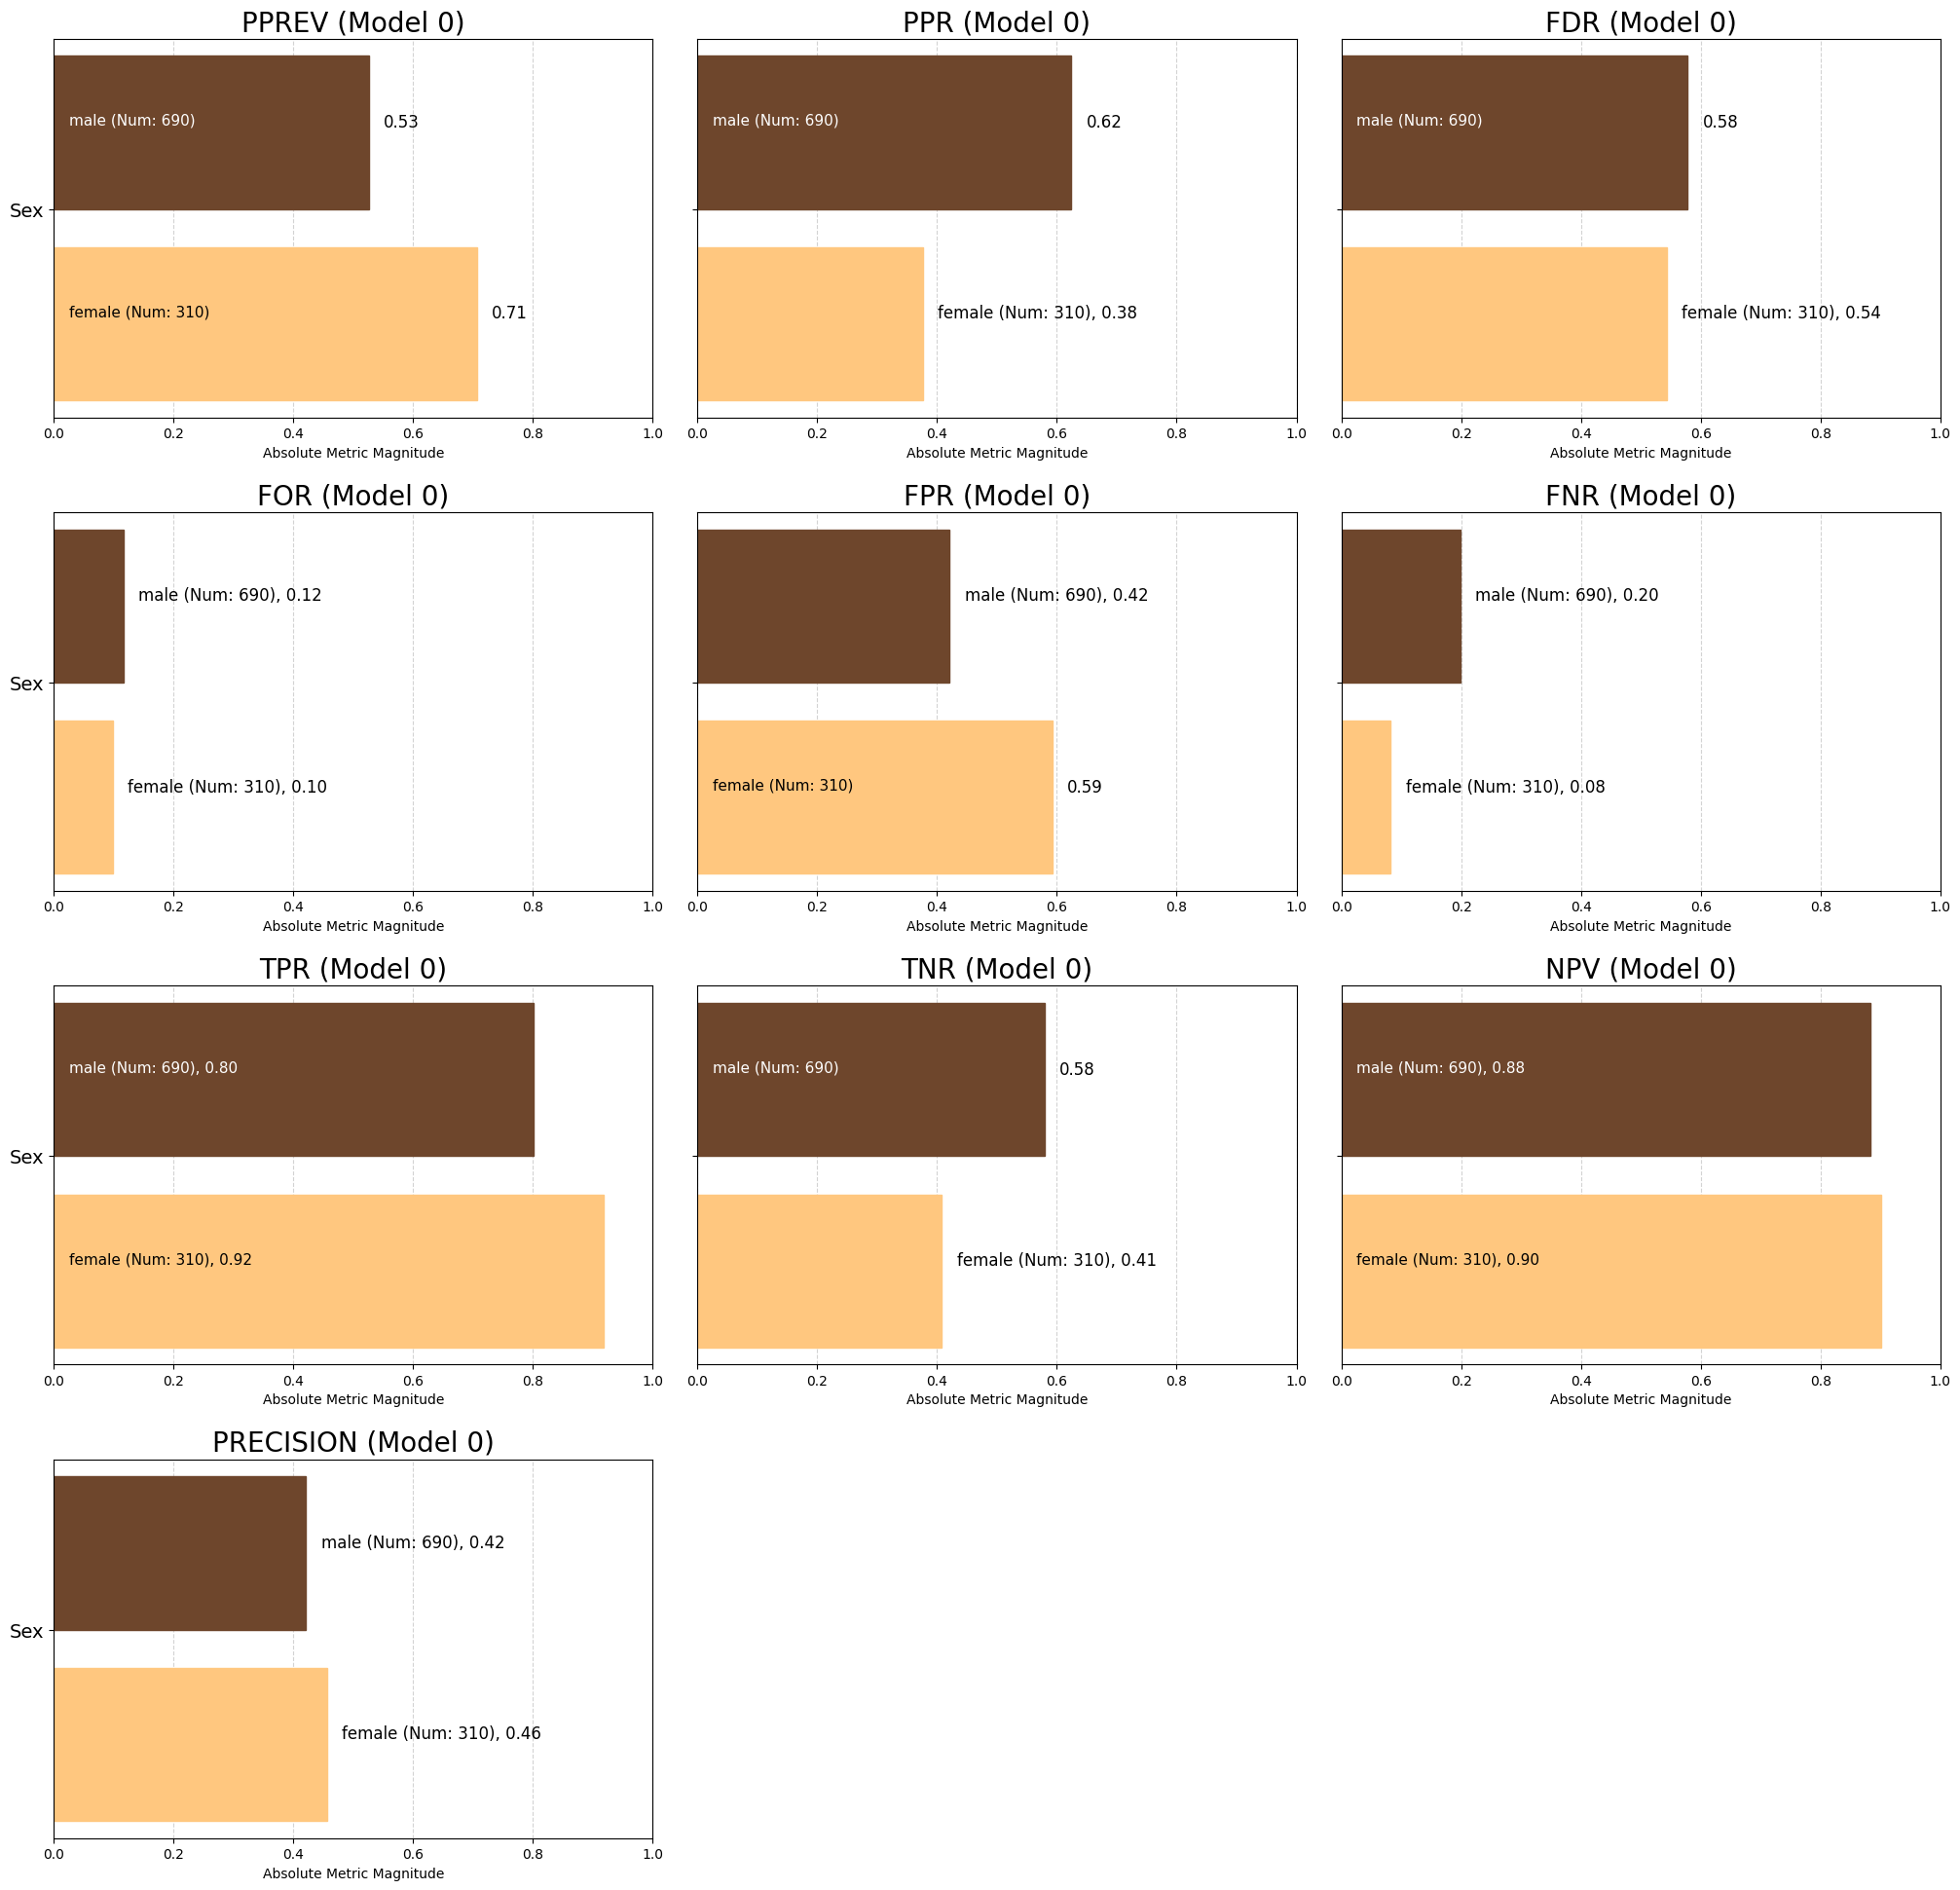

<Figure size 640x480 with 0 Axes>

In [26]:
from aequitas.plotting import Plot
aqp = Plot()
fpr_plot = aqp.plot_group_metric_all(xtab, metrics = 'all')

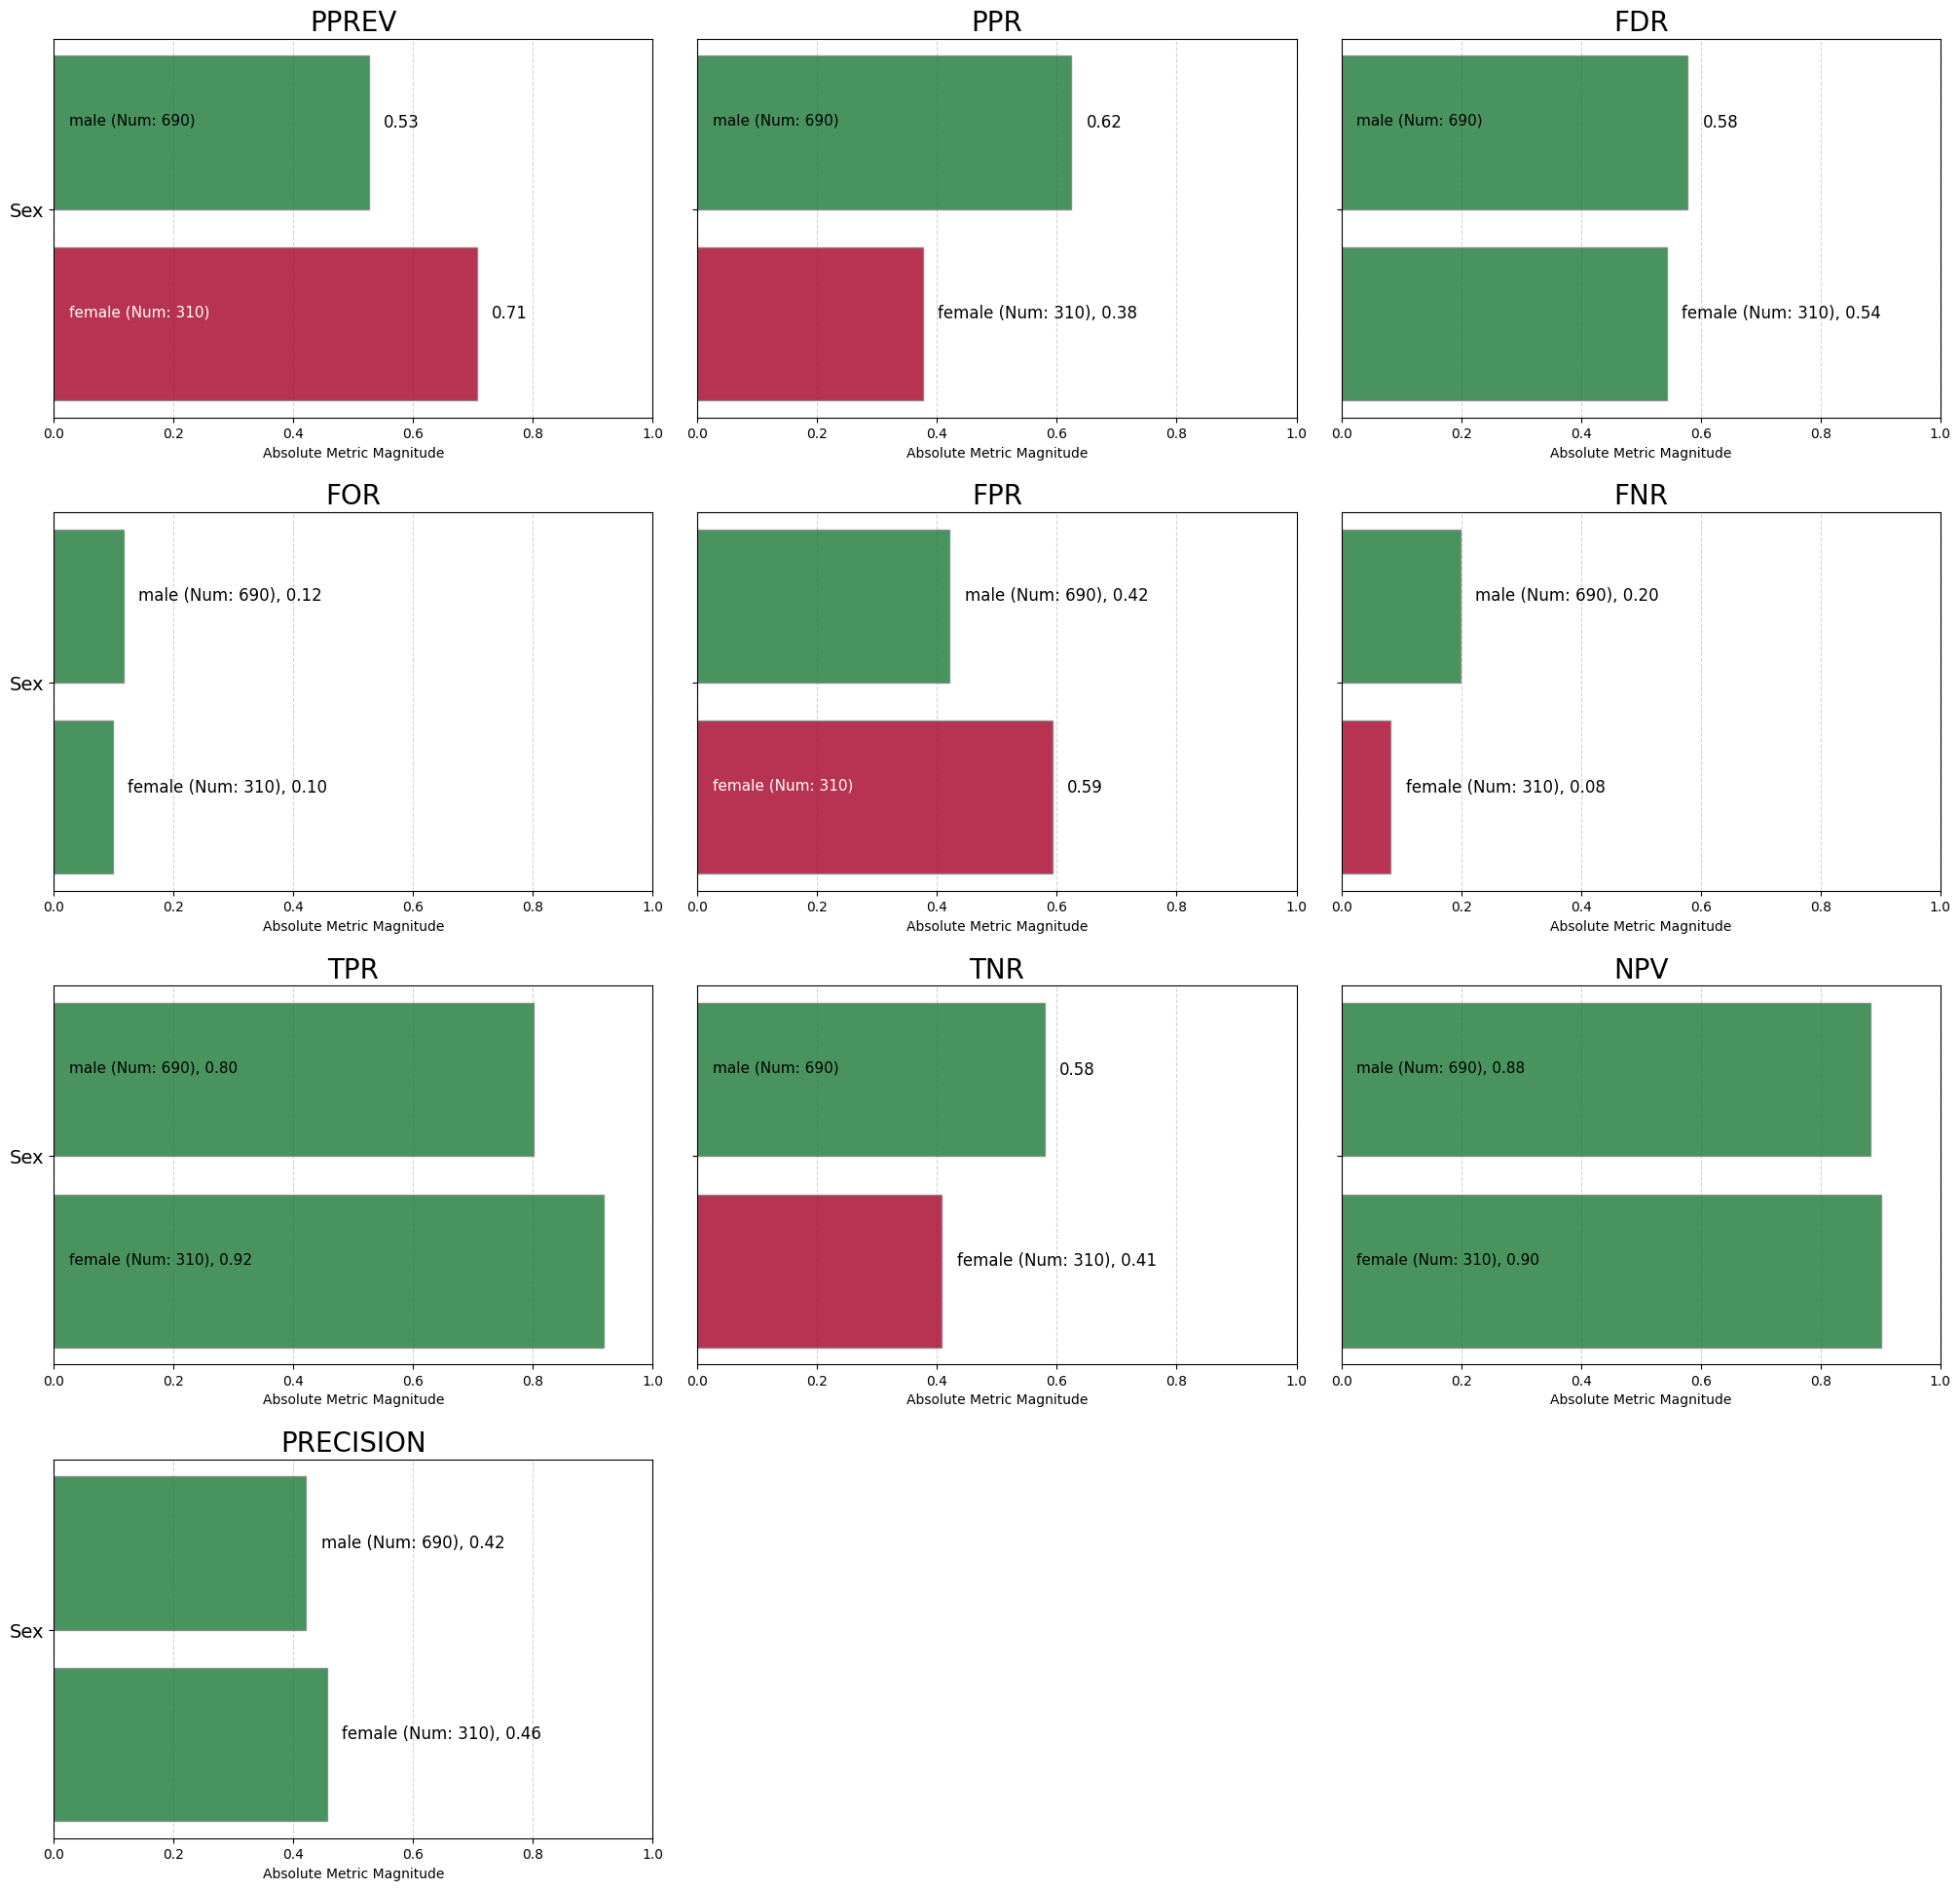

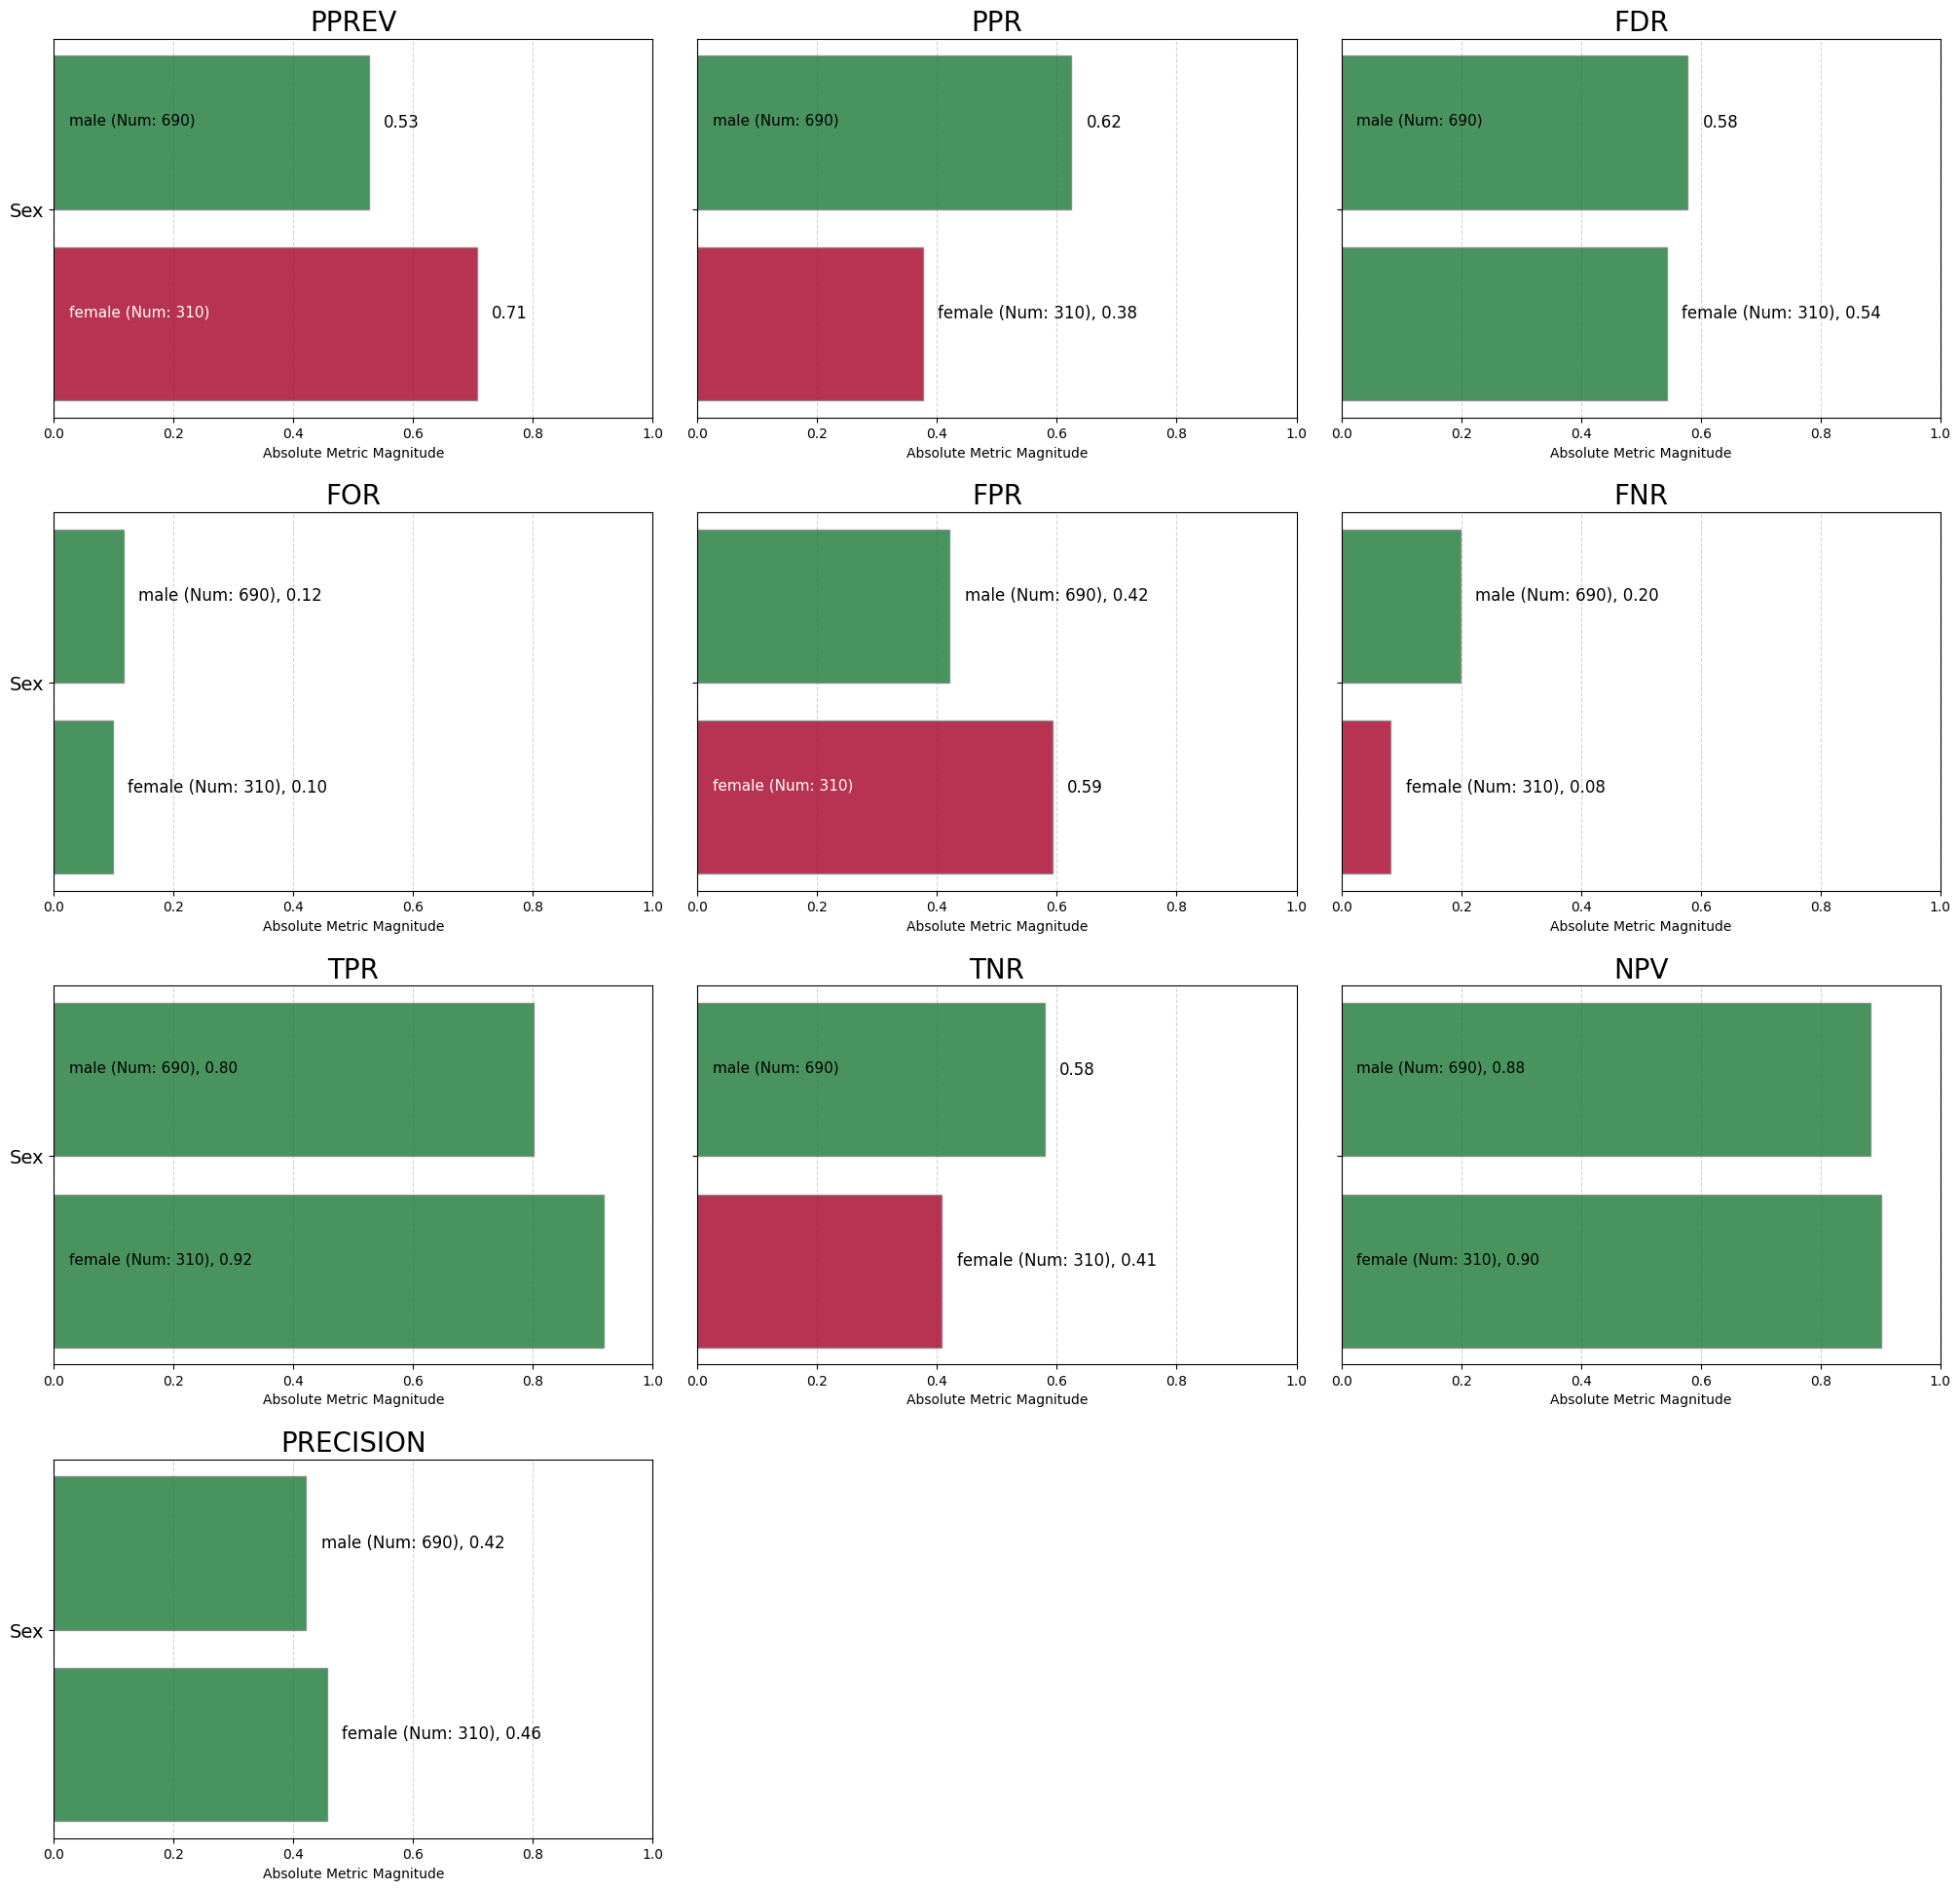

<Figure size 640x480 with 0 Axes>

In [27]:
aqp.plot_fairness_group_all(fdf, metrics='all', title=True)

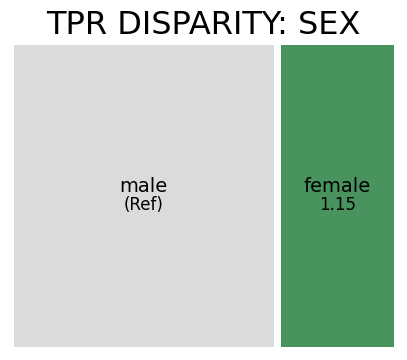

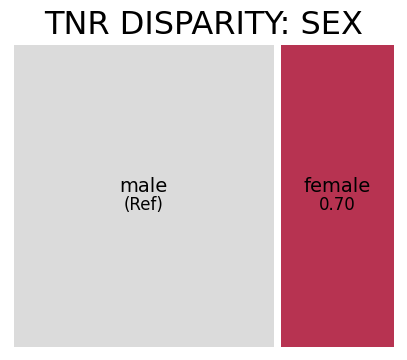

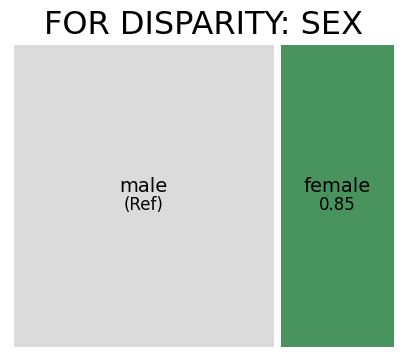

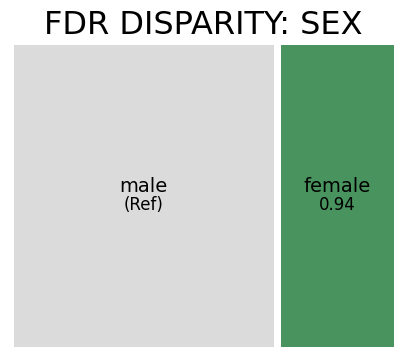

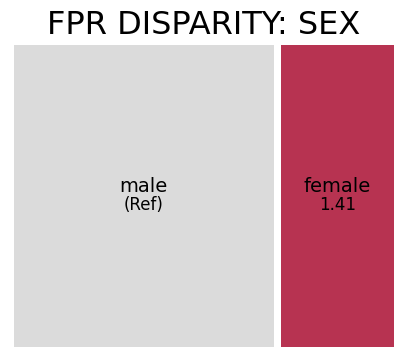

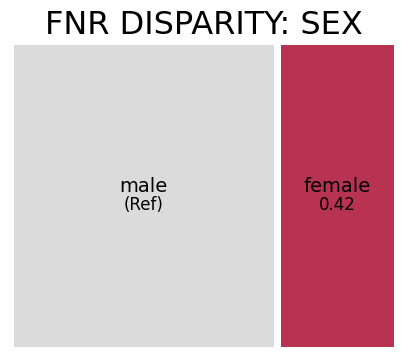

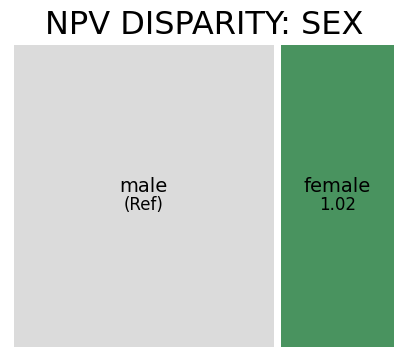

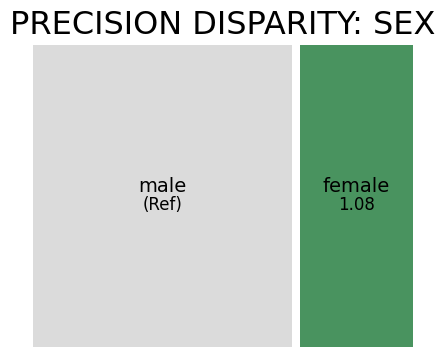

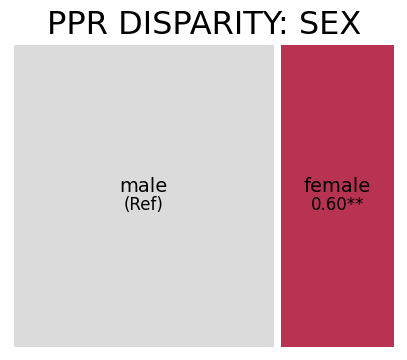

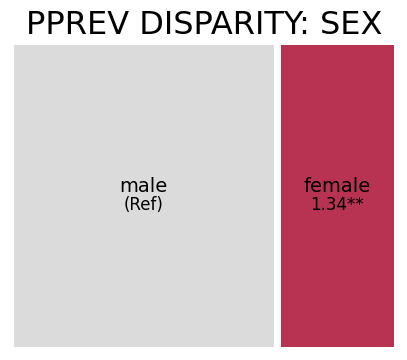

In [28]:
for metric in metrics:
    fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric=metric, attribute_name='Sex')

In [29]:
df

,Sex,score,label_value,rank_abs,rank_pct,binary_score,binary_fpr,binary_fnr,binary_ppr,binary_npv,binary_fdr,binary_tpr,binary_precision,binary_pprev,binary_for,binary_tnr
Prob_default,,,,,,,,,,,,,,,,
0.619820,female,1.0,1,1,0.001,1,0.0,NaN,1,NaN,0.0,NaN,0.0,1,NaN,0.0
0.419205,male,1.0,1,2,0.002,1,0.0,NaN,1,NaN,0.0,NaN,0.0,1,NaN,0.0
0.575317,male,1.0,1,3,0.003,1,0.0,NaN,1,NaN,0.0,NaN,0.0,1,NaN,0.0
0.241530,male,1.0,0,4,0.004,1,1.0,NaN,1,NaN,1.0,NaN,1.0,1,NaN,1.0
0.569217,female,1.0,0,5,0.005,1,1.0,NaN,1,NaN,1.0,NaN,1.0,1,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.070627,female,0.0,0,996,0.996,0,NaN,0.0,0,0.0,NaN,0.0,NaN,0,0.0,NaN
0.203788,female,0.0,1,997,0.997,0,NaN,1.0,0,1.0,NaN,1.0,NaN,0,1.0,NaN
0.052355,male,0.0,0,998,0.998,0,NaN,0.0,0,0.0,NaN,0.0,NaN,0,0.0,NaN


In [30]:
#df.to_csv("./data/aequitas_output.csv", index=False)